<a href="https://colab.research.google.com/github/ElenaBinskaya/Test_Imagewoof2/blob/main/Imagewoof2_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import accuracy_score
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import tqdm
import copy

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2.tgz
!tar -zxvf  imagewoof2.tgz

In [ ]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# папка с данными. Если запускаете в колабе, нужно скопировать данные к себе в директорию и примонтировать диск. Если запускаете локально -- просто скачайте данные
data_dir = './imagewoof2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
# специальный класс для загрузки данных в виде батчей

train_dataloader = torch.utils.data.DataLoader(
    image_datasets["train"], batch_size=32,
    shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    image_datasets["val"], batch_size=128
)

loaders = {
    "train": train_dataloader,
    "val": val_dataloader
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 4096
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier[6] = nn.Linear(num_features, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion=nn.CrossEntropyLoss()

model = model.to(device)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
              val_losses.append(epoch_loss)
              valid_accuracies.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, valid_accuracies 

In [ ]:
model_ft,train_losses, val_losses, valid_accuracies = train_model(model, criterion, optimizer,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.7252 Acc: 0.7589
val Loss: 0.4625 Acc: 0.8628

Epoch 1/9
----------
train Loss: 0.5893 Acc: 0.8050
val Loss: 0.3739 Acc: 0.8794

Epoch 2/9
----------
train Loss: 0.4991 Acc: 0.8315
val Loss: 0.3980 Acc: 0.8687

Epoch 3/9
----------
train Loss: 0.5089 Acc: 0.8285
val Loss: 0.2833 Acc: 0.9137

Epoch 4/9
----------
train Loss: 0.4513 Acc: 0.8514
val Loss: 0.3040 Acc: 0.9071

Epoch 5/9
----------
train Loss: 0.4375 Acc: 0.8558
val Loss: 0.3644 Acc: 0.8860

Epoch 6/9
----------
train Loss: 0.5322 Acc: 0.8166
val Loss: 0.2918 Acc: 0.9130

Epoch 7/9
----------
train Loss: 0.4100 Acc: 0.8625
val Loss: 0.3328 Acc: 0.9030

Epoch 8/9
----------
train Loss: 0.3962 Acc: 0.8655
val Loss: 0.3006 Acc: 0.9056

Epoch 9/9
----------
train Loss: 0.3894 Acc: 0.8710
val Loss: 0.3614 Acc: 0.8939

Training complete in 44m 57s
Best val Acc: 0.913719


In [ ]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()

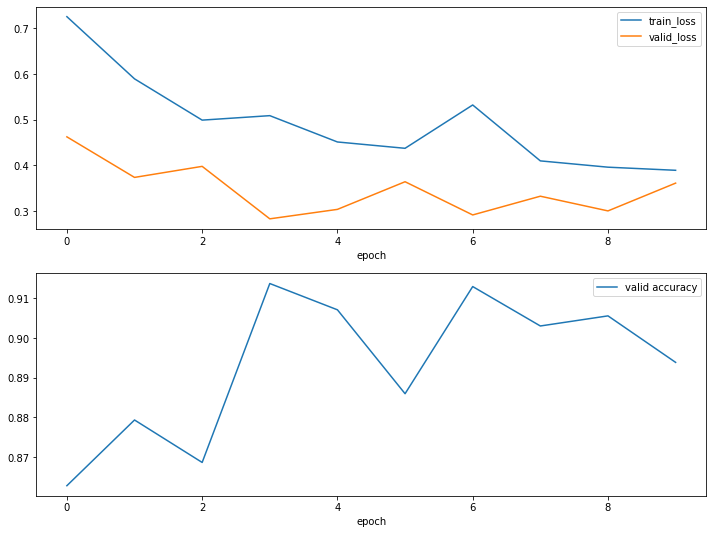

In [ ]:
plot_trainig(train_losses, val_losses, valid_accuracies)

In [ ]:
model_extractor = models.vgg16(pretrained=True)

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

model_extractor.classifier[6] = nn.Linear(num_features, 10)

# Обучаем только классификатор
optimizer = optim.Adam(model_extractor.classifier[6].parameters(), lr=1e-4)

model_extractor = model_extractor.to(device)

In [ ]:
model_ft_extractor,train_losses, val_losses, valid_accuracies = train_model(model_extractor, criterion, optimizer,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.8578 Acc: 0.7852
val Loss: 0.2521 Acc: 0.9440

Epoch 1/9
----------
train Loss: 0.4526 Acc: 0.8687
val Loss: 0.1889 Acc: 0.9501

Epoch 2/9
----------
train Loss: 0.3908 Acc: 0.8793
val Loss: 0.1676 Acc: 0.9522

Epoch 3/9
----------
train Loss: 0.3710 Acc: 0.8814
val Loss: 0.1576 Acc: 0.9547

Epoch 4/9
----------
train Loss: 0.3686 Acc: 0.8812
val Loss: 0.1524 Acc: 0.9524

Epoch 5/9
----------
train Loss: 0.3574 Acc: 0.8827
val Loss: 0.1496 Acc: 0.9539

Epoch 6/9
----------
train Loss: 0.3476 Acc: 0.8854
val Loss: 0.1460 Acc: 0.9550

Epoch 7/9
----------
train Loss: 0.3345 Acc: 0.8898
val Loss: 0.1452 Acc: 0.9550

Epoch 8/9
----------
train Loss: 0.3411 Acc: 0.8822
val Loss: 0.1435 Acc: 0.9547

Epoch 9/9
----------
train Loss: 0.3259 Acc: 0.8923
val Loss: 0.1429 Acc: 0.9552

Training complete in 26m 26s
Best val Acc: 0.955205


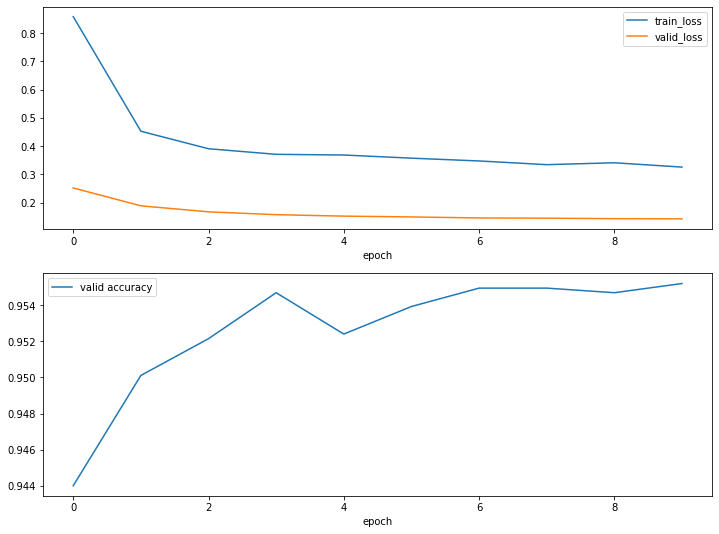

In [ ]:
plot_trainig(train_losses, val_losses, valid_accuracies)

In [ ]:
# размораживаем параметры (веса)
for param in model_ft_extractor.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model_ft_extractor.parameters(), lr=1e-5)


In [ ]:
model_ft_extractor,train_losses, val_losses, valid_accuracies = train_model(model_ft_extractor, criterion, optimizer,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3507 Acc: 0.8834
val Loss: 0.1454 Acc: 0.9516

Epoch 1/9
----------
train Loss: 0.3314 Acc: 0.8912
val Loss: 0.1433 Acc: 0.9544

Epoch 2/9
----------
train Loss: 0.3045 Acc: 0.8951
val Loss: 0.1539 Acc: 0.9514

Epoch 3/9
----------
train Loss: 0.2911 Acc: 0.9008
val Loss: 0.1595 Acc: 0.9519

Epoch 4/9
----------
train Loss: 0.2805 Acc: 0.9053
val Loss: 0.1580 Acc: 0.9537

Epoch 5/9
----------
train Loss: 0.2744 Acc: 0.9019
val Loss: 0.1589 Acc: 0.9494

Epoch 6/9
----------
train Loss: 0.2814 Acc: 0.9037
val Loss: 0.1569 Acc: 0.9516

Epoch 7/9
----------
train Loss: 0.2630 Acc: 0.9119
val Loss: 0.1614 Acc: 0.9486

Epoch 8/9
----------
train Loss: 0.2668 Acc: 0.9089
val Loss: 0.1585 Acc: 0.9544

Epoch 9/9
----------
train Loss: 0.2506 Acc: 0.9149
val Loss: 0.1584 Acc: 0.9511

Training complete in 45m 14s
Best val Acc: 0.954441


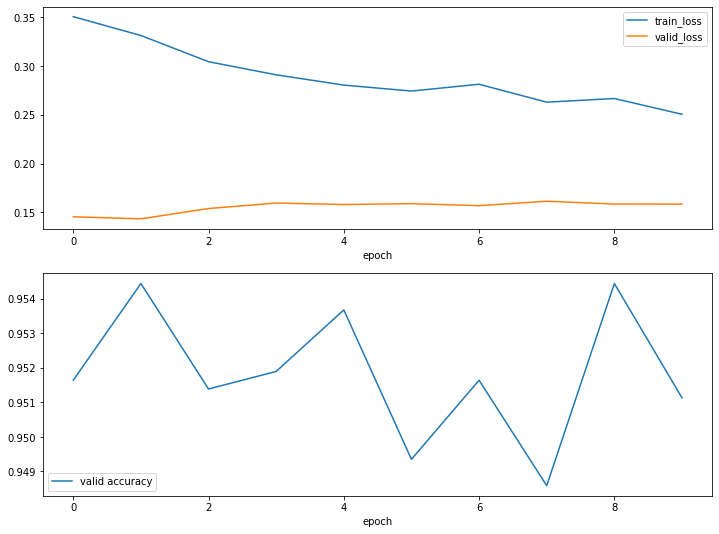

In [ ]:
plot_trainig(train_losses, val_losses, valid_accuracies)